In [1]:
%load_ext autoreload
%autoreload 2

# Maximally excitatory stimuli from trained models

This notebook illustrates how to compute the stimuli that maximally excite a specific neuron.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [2]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [3]:
if IN_COLAB:
    #@markdown **Install Flyvis**
    %%capture
    !git clone https://github.com/flyvis/flyvis-dev.git
    %cd /content/flyvis-dev
    !pip install -e .

In [4]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams['figure.dpi'] = 200

# Optimal naturalistic stimuli

We first find the optimal naturalistic stimuli. To do that, we simulate the responses of 
the network (including the neuron of interest) to all stimuli from a fixed dataset of stimuli. 
The optimal, or here maximally exctitatory naturalistic stimulus to be precise, is the stimulus 
for which the response of the chosen neuron is maximal. Finding this is simple and does not require numerical optimization with gradients.
We find the stimulus per cell type based on its cell in the central column. At least in our coarse model, 
the offset version of this stimulus would also maximally excite the equivalently offset neighboring cells of the same type.


In [5]:

from flyvision import NetworkView, results_dir
from flyvision.datasets.sintel import AugmentedSintel
from flyvision.analysis.optimal_stimuli import FindOptimalStimuli, GenerateOptimalStimuli,  plot_stim_response

In [6]:
# let's load the dataset and the pretrained network
dataset = AugmentedSintel(tasks=["lum"], temporal_split=True)
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-08-08 16:39:33] [logging_utils.py:8] Loading paper result from stored checkpoint and validation subdir...


In [7]:
findoptstim = FindOptimalStimuli(network_view, dataset)

[2024-08-08 16:39:42] [network.py:238] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-08-08 16:39:42] [chkpt_utils.py:68] Recovered network state.


In [8]:
np.random.seed(0)
indices = np.random.choice(len(dataset), 64, replace=False)

For the T4c neuron, we would expect that the maximally excitatory stimulus is an ON-edge
moving upward.

In [9]:
optstim = findoptstim.optimal_stimuli("T4c", indices=indices)

[2024-08-08 16:39:43] [network.py:728] Computing 64 stimulus responses.


Batch:   0%|          | 0/16 [00:00<?, ?it/s]

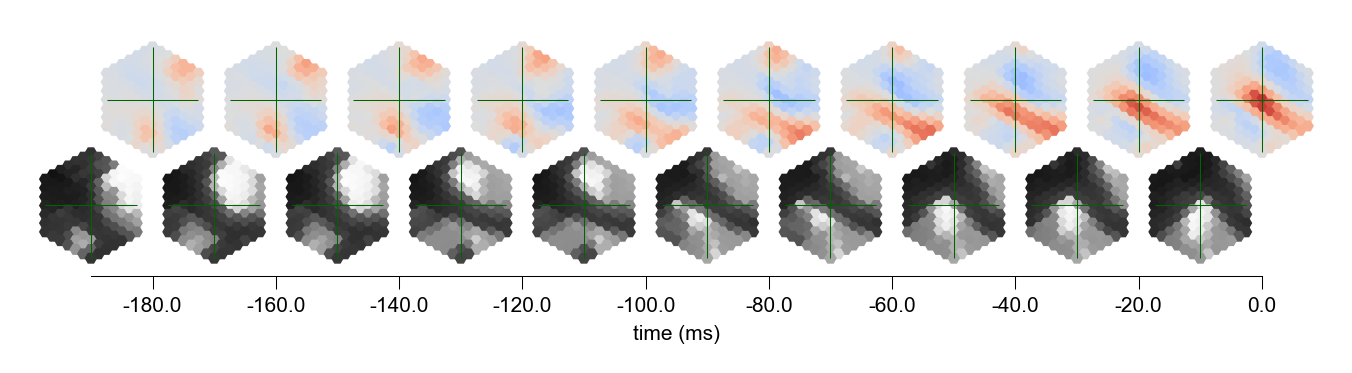

In [10]:
stim_resp_plot = plot_stim_response(optstim.stimulus, optstim.response, 1/100, *network_view.get_uv("T4c"), figsize=[5, 1.6], ylabel=None, label_peak_response=False)

We see that the the stimulus indeed contains an ON-edge component moving upward and this is the portion of the stimulus that T4c cells respond most to.
What's unclear is whether the other parts of the stimulus have an influence on the response.

# Regularized optimal stimuli

We can regularize the optimal stimuli with the objective to keep the response of the
cell intact while bringing the stimulus pixels to a neutral grey value.

In [11]:
regoptstim = findoptstim.regularized_optimal_stimuli("T4c", indices=indices)

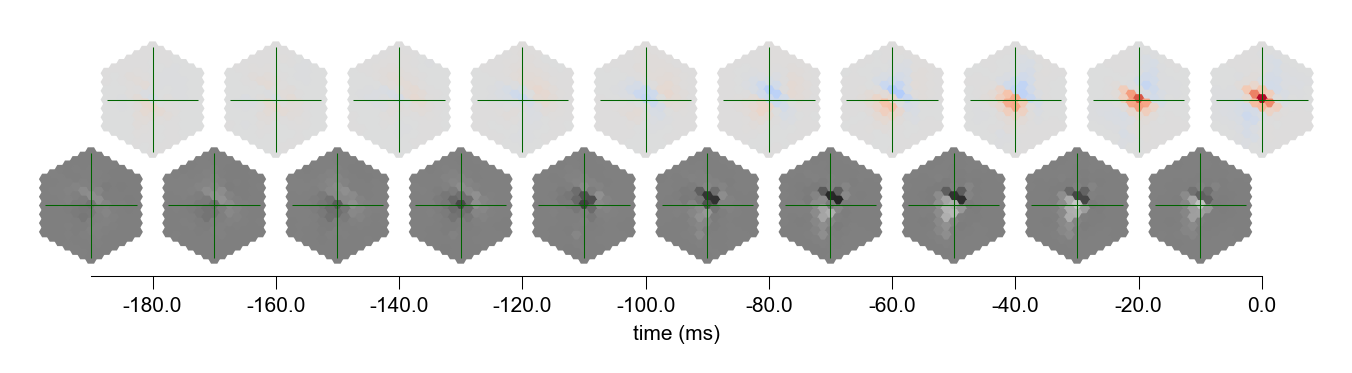

In [12]:
stim_resp_plot = plot_stim_response(regoptstim.regularized_stimulus, regoptstim.response, 1/100, *network_view.get_uv("T4c"), figsize=[5, 1.6], ylabel=None, label_peak_response=False)

This looks remarkably different! Now only a central black portion follow by the ON-edge
moving upward remains in the stimulus. Let's make sure that the central cell response is
really the same as before! This is the entire time trace.

Text(0, 0.5, 'response')

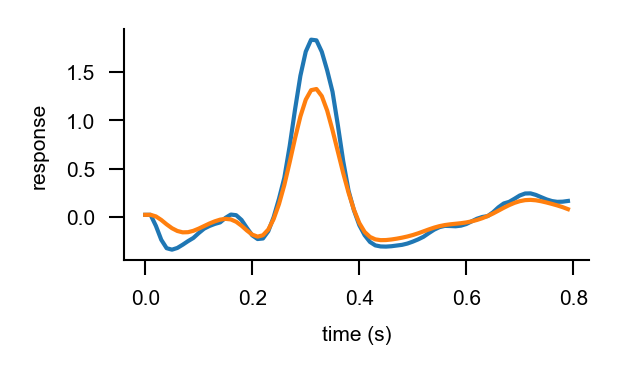

In [13]:
fig = plt.figure(figsize=[2, 1])
time = np.arange(len(regoptstim.central_target_response)) / 100
plt.plot(time, regoptstim.central_target_response)
plt.plot(time, regoptstim.central_predicted_response)
plt.xlabel("time (s)")
plt.ylabel("response")

This looks quite similar! One can play with the regularization optimization and its parameters of the function `regularized_optimal_stimuli`.

# Generate artificial optimal stimuli from scratch
If one is able to optimize the naturalistic stimulus with the gradient, why don't we
use the gradient to generate an optimal stimulus from scratch (or rather random noise).
We do that in the following. Again for T4c, we would expect that it would have some sort
of ON-edge moving upwards.

In [14]:
genoptstim = GenerateOptimalStimuli(network_view)

In [15]:
artoptstim = genoptstim.artificial_optimal_stimuli("T4c", t_stim=0.8)

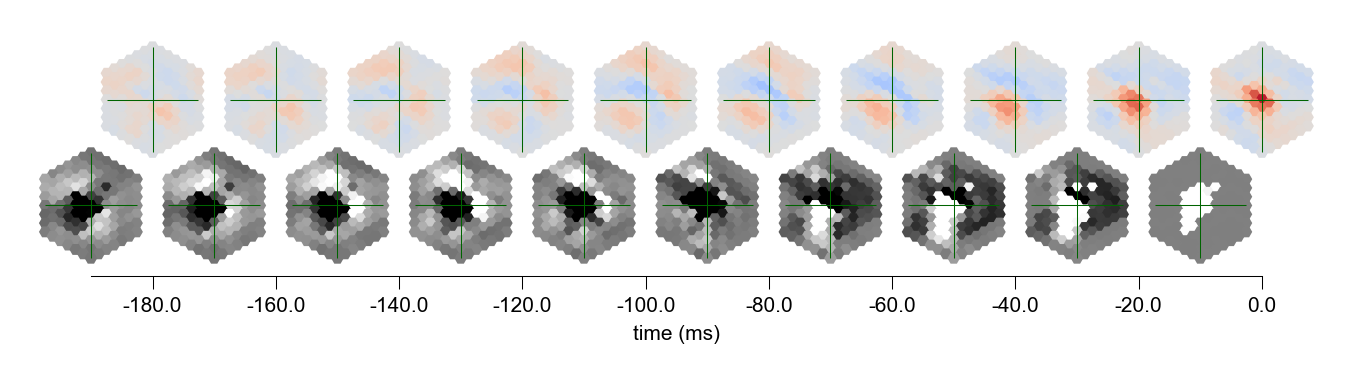

In [16]:
stim_resp_plot = plot_stim_response(artoptstim.stimulus, artoptstim.response, 1/100, *network_view.get_uv("T4c"), figsize=[5, 1.6], ylabel=None, label_peak_response=False)

Wow! This stimulus is contains very similar components to the one before and is much more
saturated! It also contains new ON-components already from the beginning!

Last, let's compare which stimulus excited the neuron the most.

In [17]:
artoptstim.response.shape

(1, 80, 721)

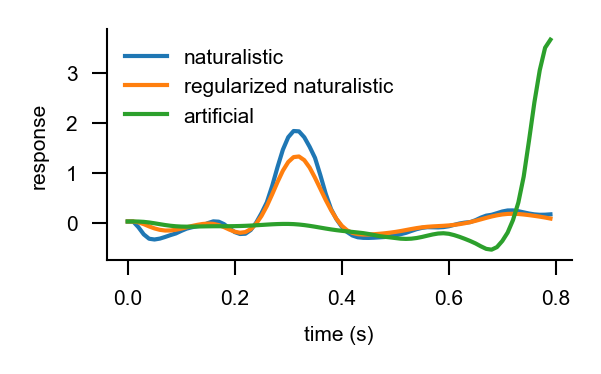

In [18]:
fig = plt.figure(figsize=[2, 1])
time = np.arange(len(regoptstim.central_target_response)) / 100
plt.plot(time, regoptstim.central_target_response, label='naturalistic')
plt.plot(time, regoptstim.central_predicted_response, label='regularized naturalistic')
plt.plot(time, artoptstim.response[:, :, artoptstim.response.shape[-1]//2].flatten(), label='artificial')
plt.xlabel("time (s)")
plt.ylabel("response")
plt.legend()